### Objective
Testing whether or not the global temperater has risen for the period of 1960 to 2010.

### Summary
Has temperature risen since 1960? We took three approaches to answer the question.

First, we performed a series of hypothesis tests, where average temperatures from four data points in the past were compared against average temperatures in 2010 to evaluate whether they are different from each other in a statistically significant way. We applied paired z-tests and P-values were adjusted by Bonferroni correction and false discovery rate. The tests revealed that global temperatures have risen in 2010 when compared to 1960, 1970, 1980, 1990 and 2000.

One of the drawbacks of our first approach is that it does not capture trend in global temperature as it just compares just two data points at a time and it is subjecet to noise present in the data. To overcome the challenge, we applied time-series analysis. First, we decomposed global temperature into trend, seasonal, and noise component in order to remove any noise and seasonal changes and extract only trend in temperatures. Then, we fitted linear regression model on temperature trend data to extract parameters such as slope. The results confirm the upward trend in global temperature during the period.

Now, the subsequent question is whether temperature increase observed at the global level is consistent across all countries. To answer the question, we delved into individual country and see if there is any variation in temperature change among the countries. In addition to visual inspection, we fitted a linear regression on each country's temperature trend data and reviewed slopes. We found that patters in temperature change are consistent across all the countries and each country has a flat or a slightly upward trend in temperatures.

### Approach 1. Hypothesis Test

First, we will test whether global temperatures have risen by comparing average temperatures in two data points - 2010 as a current temperature against past five data points (10-year increments between 1960 and 2000 - i.e. 1960,1970, 1980, 1990, and 2000)

* H0 (Null) - Global temperatures are stable since $Ti$
* Ha (alternate) - Global Temperatures are rising on average since $Ti$ . Forbes article (https://www.forbes.com/sites/peterferrara/2012/05/31/sorry-global-warming-alarmists-the-earth-is-cooling/#7e44f66f3de0)

, where $Ti$ is average temperatures in one of the 10-year increments between 1960 and 2000


* dataset1 = average temperatures $Ti$
* dataset2 = average temperatures 2010


* H0 = Mean (dataset 2) - Mean (dataset 1) = 0
* Ha = Mean (dataset 2) - Mean (dataset 1) >= 0

#### Load packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from scipy.stats import ttest_rel
from statsmodels.stats import multitest
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

#### Load and transform datasets

In [17]:
# load dataset containing smoothed average temperatures
df = pd.read_csv('../data/ewma.csv', header=0, parse_dates=[0], squeeze=True)
df.ewma = pd.to_numeric(df.ewma)
temp_col = 'ewma'

In [18]:
# get temperature of countries in $Ti$
list_years = list(range(1960, 2010 + 1, 10))
dfs = {'df_' + str(i):df[df.Year == i].reset_index()[temp_col] for i in list_years}

In [19]:
# get describtive statistics
df[df.Year.isin(list_years)] \
    .loc[:, ['Country','Year', temp_col]] \
    .pivot(index='Country', columns='Year', values=temp_col) \
    .describe()

Year,1960,1970,1980,1990,2000,2010
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,18.757030,18.610345,18.659249,18.897393,19.144096,19.406476
std,8.688498,8.820747,8.813507,8.701576,8.636002,8.625668
min,-16.951083,-17.924556,-17.851244,-18.054064,-17.477080,-16.400799
25%,11.493042,11.346447,11.215653,11.792331,12.183069,12.274578
50%,22.151333,22.226821,22.102101,22.253692,22.542708,22.515152
75%,26.113375,26.016174,26.053031,26.188096,26.357701,26.634787
max,28.701167,28.809567,29.009296,29.054247,29.372047,29.669428


#### Visualization

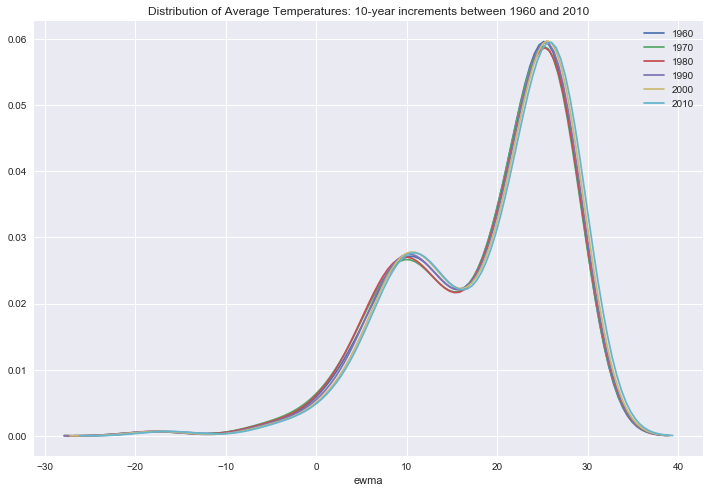

In [20]:
# compare distribution of temperatures in 10-year increments between 1960 and 2010
plt.figure(figsize=(12,8))
plt.title('Distribution of Average Temperatures: 10-year increments between 1960 and 2010')
for i in list_years:
    df_name = 'df_' + str(i)
    sns.distplot(dfs[df_name], hist=False, label=str(i))

From a quick visual inspection of the chart above, there are a few interesting points. First, in 1990 and 2000, there are more countries with a average temperature between 10 and 10 while less countries with a temperature between -10 and 10. This suggests temperatures have risen among countries with a lower temperature. Also, in 2010, the entire distribution has slightly shifted to the right (i.e. higher temperatures).

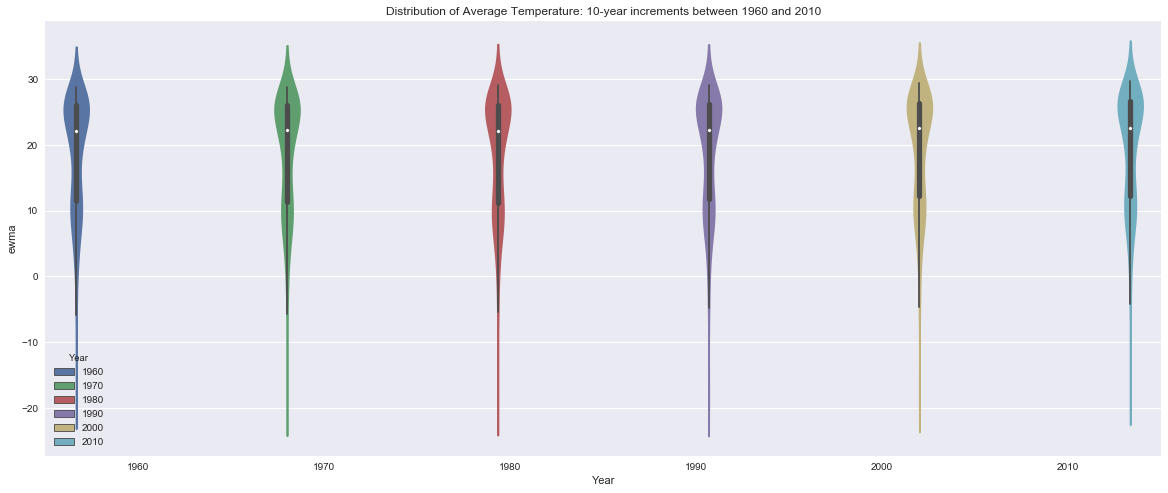

In [21]:
# compare distribution of temperatures in 1990 and 2010
plt.figure(figsize=(20,8))
plt.title('Distribution of Average Temperature: 10-year increments between 1960 and 2010')
df_violin = df[df.Year.isin(list_years)].loc[:,['Year', temp_col]]
sns.violinplot(x='Year', y=temp_col, hue='Year', data=df_violin);

It's hard to see, but again, the entire distribution has slightly shifted to the right in 2010. Let's test if that is the case.

#### Hypothesis Test

In [22]:
# perform multiple paired t-test

list_years_short = list_years[:-1]

list_pvalue = []
list_stats = []

for i in list_years_short:
    df_past = 'df_' + str(i)
    test_result = ttest_rel(dfs['df_2010'], dfs[df_past])
    list_pvalue.append(test_result.pvalue)
    list_stats.append(test_result.statistic)

df_result = pd.DataFrame({'Year':list_years_short, 'stats':list_stats, 'pvalue':list_pvalue})

We need to adjust the p-values because, as we learned from Week 4 of the lectures, we can be almost certain we would find something unusual just by chance if we test sufficiently many time. I will perform Bonferroni correction and compute false discovery rate (FDR) and use adjusted p-values to avoid false rejections.

In [23]:
# Bonferroni correction
bf_result = multitest.multipletests(df_result.pvalue, alpha=0.05, method='bonferroni')
bf_pvalue = bf_result[0]
bf_stats = bf_result[1]

In [24]:
# false discovery rate
fdr_result = multitest.multipletests(df_result.pvalue, alpha=0.05, method='fdr_bh')
fdr_pvalue = fdr_result[0]
fdr_stats = fdr_result[1]

In [25]:
# combine results
df_result['bf_pvalue'] = bf_pvalue
df_result['bf_stats'] = bf_stats
df_result['fdr_pvalue'] = fdr_pvalue
df_result['fdr_stats'] = fdr_stats

In [26]:
df_result.set_index('Year')

,pvalue,stats,bf_pvalue,bf_stats,fdr_pvalue,fdr_stats
Year,,,,,,
1960,3.396808e-59,24.877221,True,1.698404e-58,True,4.246010e-59
1970,1.952404e-78,33.831306,True,9.762021e-78,True,9.762021e-78
1980,2.411251e-76,32.765959,True,1.205625e-75,True,6.028127e-76
1990,5.835738e-60,25.200531,True,2.917869e-59,True,9.726230e-60
2000,7.815594e-43,18.457689,True,3.907797e-42,True,7.815594e-43


#### Results

All the p-values are significantly less than 0.025 and null hypothesis that average temperatures are stable is rejected. Also, all the z-statistics are positive, which indicates that global Temperatures have risen in 2010 when compared to 1960, 1970, 1980, 1990 and 2000.

Now, one of the drawbacks of this approach is that it does not capture trend in global temperature and does not follow temperature over the time as it just compares two data points. It can be problematic especially when large amount of noise exisits in the dataset. This calls for more sophisticated statistical methods, and we will turn to time-series analyses.

### Approach 2: Time-series analysis with average temperatures at the global level


First, let's look at the changes in Earth's global average surface temperature, instead of looking at individual countries. Again, we are focusing on the period of 1960 and 2012 to be consistent with the rest of the analyses. 

#### Data clensing

In [27]:
# bring in the monthly global temperature data
df_temp_raw = pd.read_csv('..\data\GlobalTemperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# define start and end date 
START_DT = '1960-01-01'
END_DT = '2012-12-31'

# create a dataframe for Annualized Average Temperature
df_temp_yr = df_temp_raw.loc[START_DT:END_DT].LandAverageTemperature.resample('A').mean()
df_temp_yr.head()

dt
1960-12-31    8.583750
1961-12-31    8.797667
1962-12-31    8.745917
1963-12-31    8.856000
1964-12-31    8.409667
Freq: A-DEC, Name: LandAverageTemperature, dtype: float64

#### Expoloratory data analysis

In [28]:
pd.DataFrame(df_temp_yr).describe()

,LandAverageTemperature
count,53.000000
mean,9.004667
std,0.386552
min,8.347250
25%,8.692750
50%,8.948250
75%,9.324583
max,9.732167


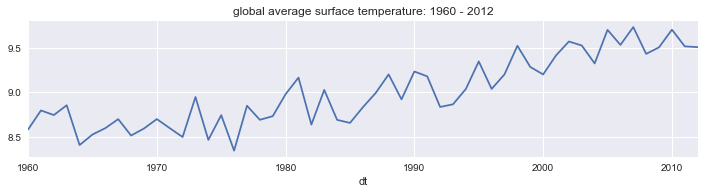

In [29]:
plt.figure(figsize=(12,2.5))
plt.title('global average surface temperature: 1960 - 2012')
df_temp_yr.plot();

The chart above illustrates global average temperature for the period of 1960 to 2012. It appears to have an upward trend but it is hard to confirm that because it fluctuates year by year. Now, let's extract the trend from the chart by removing seasonal component and noises, and for that, we will apply structural modling covered by Week 4 of our course.

#### Modeling: Structural Modeling/Decomposition

Structural Modeling views a given time series as a function of a general trend, along with a seasonal cycle.

$xt=Tt+St+Nt$
 
where
$T_t$ = trend component,
$S_t$ = seasonal component,
$N_t$ = noise.

We will essentially estimate the effect that each component has on the series that we are faced with, at different points in that series.

This procedure is so popular that it gets its own function. There are two parameters that we will want to set - first is the model parameter, which we set to 'additive,' as indicated by the above specification. We are also going to need to set the freq parameter, which is referring to the periodicity of the time series. In our case, I explored several options ranging from 20 to 30 years based on the Forbes article, and settled on 25 years.

In [30]:
decomp = seasonal_decompose(x=df_temp_yr, model='additive', freq=25)

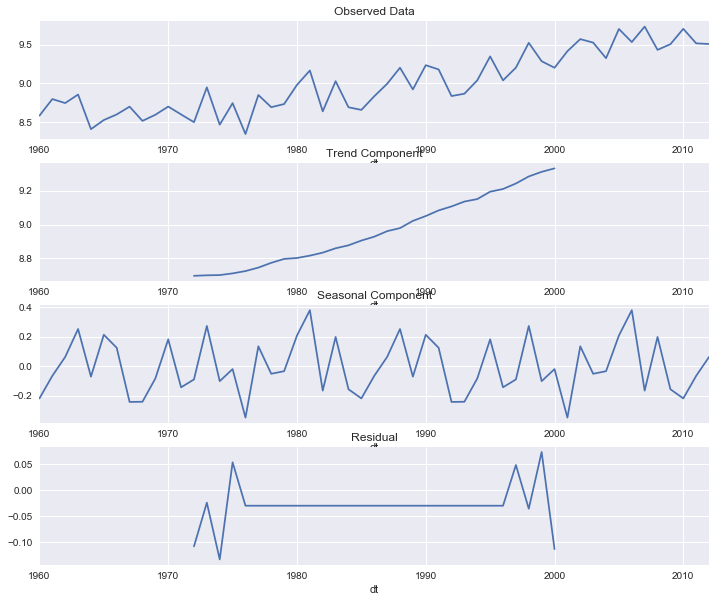

In [31]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10))
decomp.observed.plot(ax=ax1)
ax1.set_title('Observed Data')
decomp.trend.plot(ax=ax2)
ax2.set_title('Trend Component')
decomp.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal Component')
decomp.resid.plot(ax=ax4)
ax4.set_title('Residual');

These results are interesting. First, we are presented with average temperatures. Next, we are given the general trend component. From this, we can see an obvious pattern - global temperature has been increasing over time. We can also see a changepoint occuring right after the trend line becomes available, and we can see that the rate at which average temperature has risen is linear. Now, let's fit a linear line on decomposed trend temperatures and get parameters of the model to better understand the trend.

In [32]:
# quick data cleansing for visuallization
df_trend = pd.DataFrame(decomp.trend).reset_index().dropna()
df_trend['year'] = df_trend.dt.dt.year

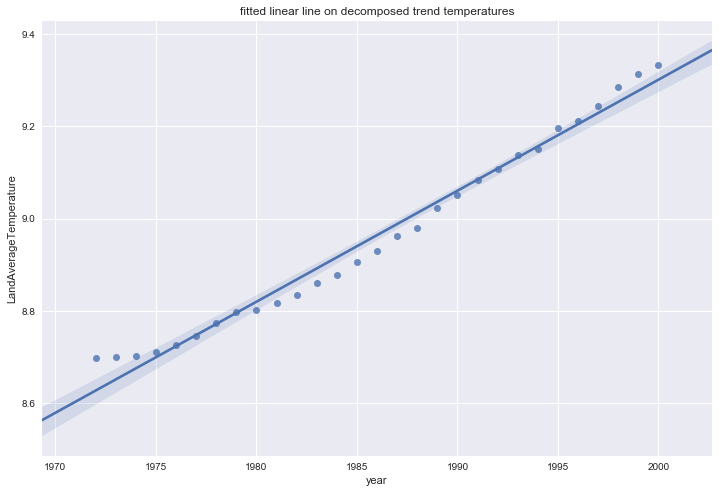

In [86]:
# plot data points and a fitted linear trend line
plt.figure(figsize=(12,8))
# plt.ylim(-20, 30)
plt.title('fitted linear line on decomposed trend temperatures')
sns.regplot(x='year', y='LandAverageTemperature', data=df_trend);

In [34]:
# get stats on the fitted line
slope, intercept, r_value, p_value, std_err = stats.linregress(df_trend['year'], df_trend['LandAverageTemperature'])

In [35]:
print('slope: ' + str(slope))
print('p-value: ' + str(p_value))

slope: 0.024073975369458055
p-value: 3.3580736844625425e-25


#### Results
The fitted trend line has a slope of 0.024 with P-value of 3.35e-25. This indicates that global average temperature has risen by 0.024 celcius degree every year since 1972. The results confirm the upward trend in global temperature during the period .

### Approach 3: Time-series analysis with average temperatures at the individual-country level

While our analysis above confirms there is a upward linear trend in global between 1960 and 2012, we would like to investigate further at the individual country level to get a sense of the varition of trends in temperature at each country. The main question we would like to address here is temperature increase observed at the global level is consistent across all countries (i.e. all the countries have an upward trend in its temperature), or it varies among countries (i.e. some countries have an steep upward trend but others have a downward trend).



#### Data clensing

In [36]:
# load and clean dataset
df_raw = pd.read_csv('../data/ADS_project_dataset2.csv', header=0, parse_dates=[0], squeeze=True)

df_small = df_raw[(df_raw.Year >= 1960) & (df_raw.Year <= 2012)]\
    .loc[:,['Country', 'Year', 'AveTemperature']]\
    .sort_values(['Country', 'Year'])\
    .reset_index(drop=True)

df_small.Year = pd.to_datetime(df_small.Year, format='%Y')
df_small = df_small.set_index('Year')

#### Modeling: Structural Modeling/Decomposition
Let's perform the same structural modeling and decomposition on temperature data at the individual-country level.

In [71]:
list_country = list(df_small.Country.unique())

# decompose temperatures for each country
for i in list_country:
    series_temp = df_small[df_small['Country'] == i]['AveTemperature']
    decomp_result = seasonal_decompose(x=series_temp, model='additive', freq=25)
    df_result = pd.DataFrame({'observed': decomp_result.observed,
              'country': i,
              'trend': decomp_result.trend,
              'seasonal': decomp_result.seasonal,
              'resid': decomp_result.resid})
    df_master_result = df_master_result.append(df_result)

# clean data for plotting
df_master_result_sm = df_master_result.dropna().reset_index().loc[:,['Year', 'country', 'trend']]
df_master_result_sm['Year'] = df_master_result_sm['Year'].dt.year

In [85]:
# save dataframe
df_master_result_sm.to_csv('../data/df_master_result_sm.csv', index=False)

Let's plot a fitted linear line for individual countries to visually inspend if there is any country with a downward trend.

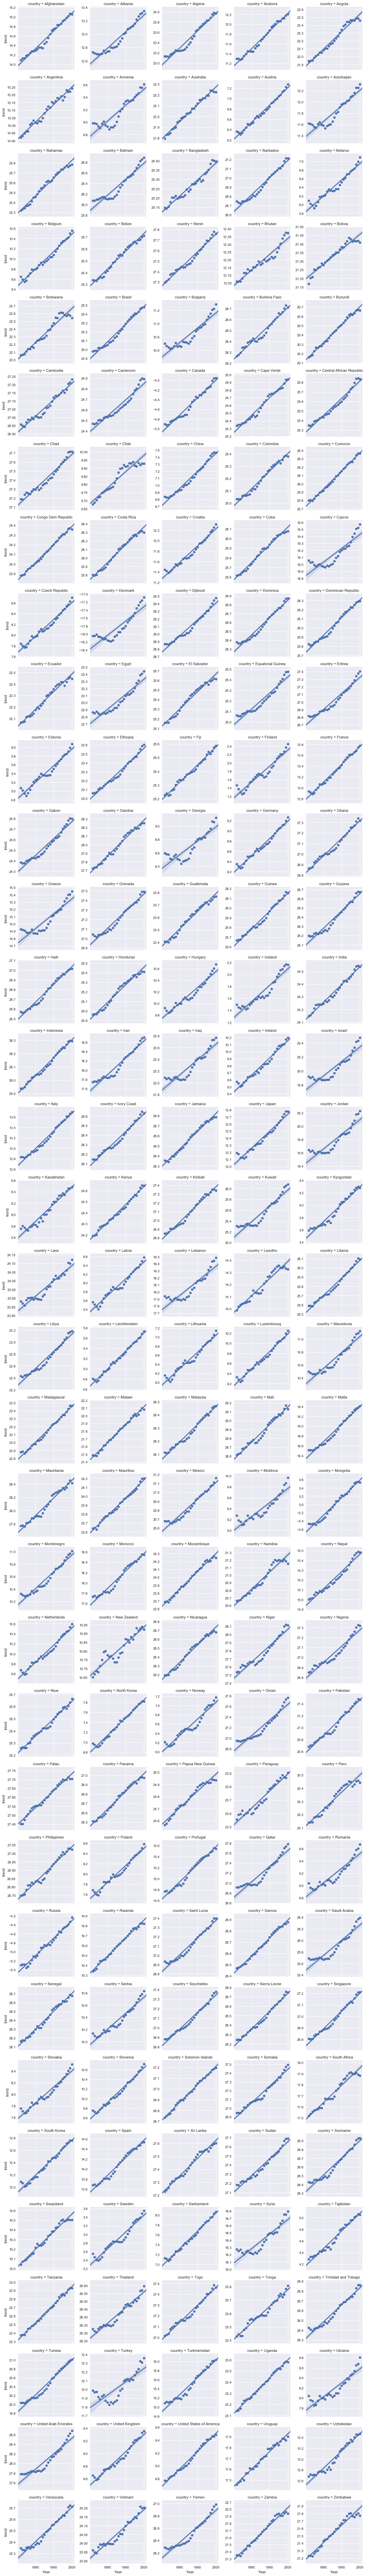

In [88]:
# plot fitted linear lines
g = sns.FacetGrid(df_master_result_sm, col="country", col_wrap=5, sharey=False) 
g.map(sns.regplot, "Year", "trend");

It's exactly like what we have done at the global level, but this time, each country has its own fitted line. Visually inspected, all the countries have a stable or a slightly upward trend line. Let's check the slope of the fitted lines for these countries to see if there is any negative one.

In [79]:
# fit a trend line on decomposed trend temperatures at the individual country level
list_country_master = []
list_slope_master = []
list_intercept_master = []
list_r_value_master = []
list_p_value_master = []
list_std_err_master = []

for j in list_country:
    df_result = df_master_result_sm[df_master_result_sm.country == j].dropna()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_result.index, df_result.trend)
    list_country_master.append(j)
    list_slope_master.append(slope)
    list_intercept_master.append(intercept)
    list_r_value_master.append(r_value)
    list_p_value_master.append(p_value)
    list_std_err_master.append(std_err)

df_fit = pd.DataFrame(
    {
        'country':list_country_master,
        'slope':list_slope_master,
        'intercept':list_intercept_master,
        'r_value':list_r_value_master,
        'p_value':list_p_value_master,
        'std_err':list_std_err_master
             })

In [84]:
# save the dataframe
df_fit.to_csv('../data/df_fit.csv', index=False)

In [77]:
# get basic stats on slope
df_fit.describe()

,intercept,p_value,r_value,slope,std_err
count,175.000000,175.000000,175.000000,1.750000e+02,175.000000
mean,18.891545,0.980887,0.003216,2.499300e-07,0.000010
std,8.721580,0.000506,0.000085,8.981580e-08,0.000004
min,-17.821581,0.980442,0.002722,9.459746e-08,0.000004
25%,11.742726,0.980590,0.003202,1.826652e-07,0.000008
50%,22.286182,0.980705,0.003246,2.253902e-07,0.000010
75%,26.192563,0.980968,0.003266,3.174426e-07,0.000013
max,29.100062,0.983823,0.003291,4.626204e-07,0.000019


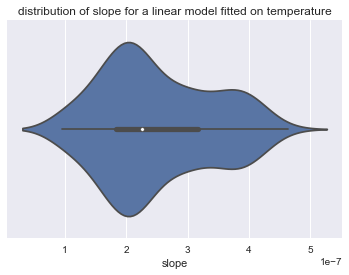

In [78]:
plt.title('distribution of slope for a linear model fitted on temperature')
sns.violinplot(df_fit['slope']);

#### Results
The chart agove illustrates the distribution of slope for a linear model fitted on temperature at the individual country level. The slopes are slightly but all positive. This confirms our insight from visual inspection that temperature change, if any, are consistent across all the countries.